---
# **1. DESCRIPTION OF THE IDEA FOR THE TASK**
---


Th idea of the analysis was born after a careful review of relevant literature (see summary word doc in repo) of anomaly detection, prediction and an article ["Open Challenges in Time Series Anomaly Detection: An Industry Perspective"](https://arxiv.org/abs/2502.05392) published by Microsoft where the real challenges practitioners face while implementing models into system were explained. 


In the article ["Predicting  SLA Violations in Real Time using Online Machine Learning"](https://arxiv.org/abs/1509.01386) the authors address the challenge of ensuring real-time service quality in telecom environments, which is increasingly complex as services migrate to the cloud.

### Problem: offline limitations

1. **Core challenge:** service assurance systems must detect and predict Service Level Agreement (SLA) violations to prevent business and reputation loss.

2. **Predictive difficulty:** predicting these violations is difficult because user demands and infrastructure loads change over time.

3. **Concept drift:** traditional offline machine learning assumes data is drawn from a stationary distribution (it doesn't change). In reality, this distribution evolves. This is called "concept drift" which causing offline models trained on old data to become inaccurate as system behavior changes.

4. **Goal:** to predict application-level SLA (whether the service quality is "violated" or "not violated") based on server-side device statistics ($X$), even when the underlying data distribution changes over time.

### Proposed solution: online machine learning

1. **Service agnostic approach:** authors propose an online learning method that learns system behavior "on the fly" from a continuous stream of data.

2. **Streaming metrics:** system uses low-level device metrics ( CPU usage, free memory, context switches, else...) collected at the server to predict client-side performance.

3. **Incremental learning:** unlike offline methods that require a separate, static training phase, online method gradually improves its understanding as new data arrives.

4. **Effectiveness:** results demonstrate that online methods—specifically the Online Accuracy Update Ensemble (OAUE)—can achieve over 90% classification accuracy and maintain high performance even when load patterns change abruptly

### Researchers do real-time detection: 
Prediction of a binary state (SLA violated vs. not violated) at the current moment in real-time. It aims to determine if the current server statistics ($X$) imply that the client is currently experiencing a quality drop.

### What I do in my analysis:

I try to predict future incidents using a lead-time horizon ($H$). Specifically, I use previous $W$ seconds of server metrics to predict whether an incident will occur at least once in the next $H$ seconds. 

we wanna predict crash from good state


---
# **2. DESCRIPTION OF THE DATA**
---

### **Dataset: Linux kernel statistics from a video server and service metrics from a video client**

**Sourse:** [dataset](https://mldata-static.ml.tu-berlin.de/repository/data/viewslug/realm-im2015-vod-traces/index.html)


The dataset consists of 21 specific server metrics matched against video quality measurements taken every second. It is built to show how server stress directly causes video lag. This dataset is well-suited for **incident prediction** because it links server-side statistics to user-visible degradation events. It contains synchronized time series sampled every second (1 Hz) from a video-on-demand service:

1. **Server metrics: $𝑋$** 21 Linux/kernel (SAR-style) system metrics describing server load and resource usage (CPU, memory, process activity, network-related counters, else...).

2. **Client QoS $𝑌$**: service-quality measurements from the video client, including **FPS (frame rate)** and **ABS (audio buffer-related metric)**.

3. **Incident or label**: we define an **incident** as a QoS/SLO violation when **FPS < 20 (optionally also ABS < 20)**. For a given task I construct a sliding-window dataset where each example uses the previous **$𝑊$** seconds of server metrics to predict whether an incident will occur at least once in the next 
**$H$** seconds.
















### **2.1. Import packages**
---

In [1]:
# packages for dealing with data
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# my helpers
from helpers import *

# packages for modelling offline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, balanced_accuracy_score

# packages for modelling online
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from river import tree  # HoeffdingTreeClassifier

### **2.2. Inspect the structure of the data**
---

Download data

In [2]:
# directory
root = Path(r"C:\Users\oleks\Desktop\jetbrain\data")

def load_all(folder):
    """
    Function is looking for any subfolder with cvs files, reads them, 
    and put them into DataFrame.
    Adds columns to track which folder and file the data came from.
    """
    files = list((root / folder).rglob("*.csv"))
    return pd.concat(
        [pd.read_csv(f).assign(dataset=folder, file=f.stem) for f in files],
        ignore_index=True
    )

X_PROC = load_all("X_PROC")
X_SAR  = load_all("X_SAR")

print(X_PROC.shape, X_SAR.shape)

(139084, 4589) (225564, 871)


All data are in cvs format and structured as shown in summary below. Since the number of NA is very low is assumed that they do not have any significant impact on analysis. It was decided to proceed without imputing missing data. 

In [3]:
files = sorted(root.rglob("*.csv"))

rows = []
for f in files:
    df = pd.read_csv(f)
    # count NA
    na = df.isna().sum().sum()
    rows.append({
        "file": str(f.relative_to(root)),
        "rows": df.shape[0],
        "cols": df.shape[1],
        "na_cells": int(na),
        "na_%": float(na / df.size) if df.size else 0.0,
    })

# show summary
summary = pd.DataFrame(rows).sort_values(["file"])
summary

,file,rows,cols,na_cells,na_%
0,X_PROC\constant_load\X.csv,16964,4571,0,0.000000
1,X_PROC\constant_load\Y.csv,16964,16,0,0.000000
2,X_PROC\flashcrowd_load\X.csv,12096,4571,0,0.000000
3,X_PROC\flashcrowd_load\Y.csv,12096,16,0,0.000000
4,X_PROC\linear_increase\X.csv,16447,4571,0,0.000000
5,X_PROC\linear_increase\Y.csv,16447,16,0,0.000000
6,X_PROC\periodic_load\X.csv,12023,4571,0,0.000000
7,X_PROC\periodic_load\Y.csv,12023,16,0,0.000000
8,X_PROC\poisson_load\X.csv,12012,4571,0,0.000000
9,X_PROC\poisson_load\Y.csv,12012,16,0,0.000000


Check the columns and make a report with the names of the columns in order to choose the ones for modelling

In [4]:
# define how data are stored
sources = ["SAR", "PROC"]
types = ["X", "Y"]
scenarios = ["constant_load", "flashcrowd_load", "linear_increase", "periodic_load", "poisson_load"]

dfs = {}

# iterate over sources and types
for src, t in product(sources, types):
    var_name = f"X_{src}_{t}"
    # for each scenario, find cvs's and collect them
    dfs[var_name] = pd.concat(
        [pd.read_csv(root / f"X_{src}" / s / f"{t}.csv").assign(scenario=s) for s in scenarios],
        ignore_index=True
    )
    # print first 5 from each scenario
    print(f"{var_name} columns: {dfs[var_name].columns.tolist()[:5]}")


# save the report with names columns 
with open("1_EDA_all_columns.txt", "w") as f:
    for name, df in dfs.items():
        f.write(f"----------- {name} Columns -----------\n")
        # every single column name for a given dataset
        f.write("\n".join(df.columns.tolist()))
        f.write("\n" * 20) 
    print("The whole report was saved in current repository:) ")

X_SAR_X columns: ['TimeStamp', 'all_%%usr', 'all_%%nice', 'all_%%sys', 'all_%%iowait']
X_SAR_Y columns: ['TimeStamp', 'LostFrames', 'noAudioPlayed', 'noAudioPlayedAvg2', 'noAudioPlayedAvg5']
X_PROC_X columns: ['Time stamp (system)', '/proc/buddyinfo_line_3_value11', '/proc/buddyinfo_line_3_value10', '/proc/buddyinfo_line_3_node_number', '/proc/buddyinfo_line_1_node_number']
X_PROC_Y columns: ['TimeStamp', 'LostFrames', 'noAudioPlayed', 'noAudioPlayedAvg2', 'noAudioPlayedAvg5']
The whole report was saved in current repository:) 


### **2.3. Plot some variables**
---

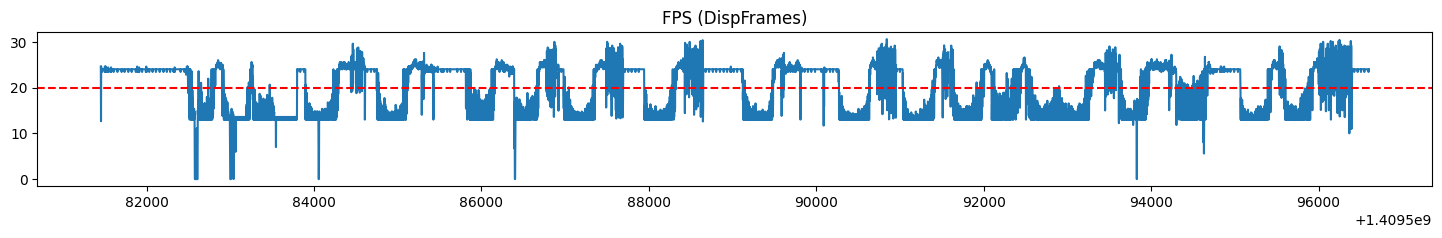

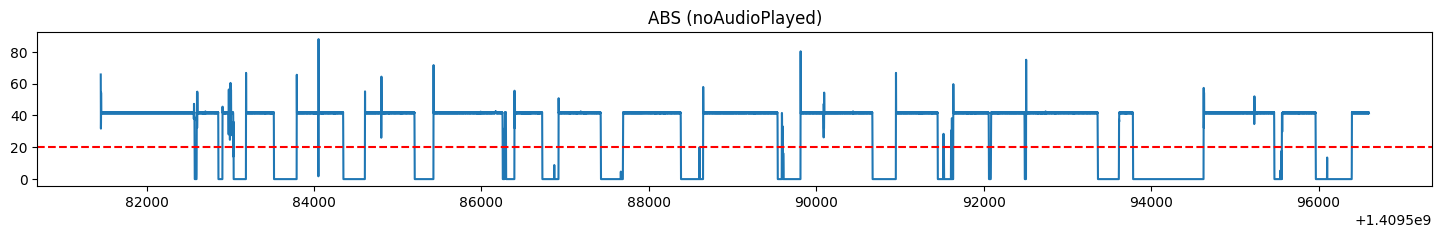

(-0.1, 1.1)

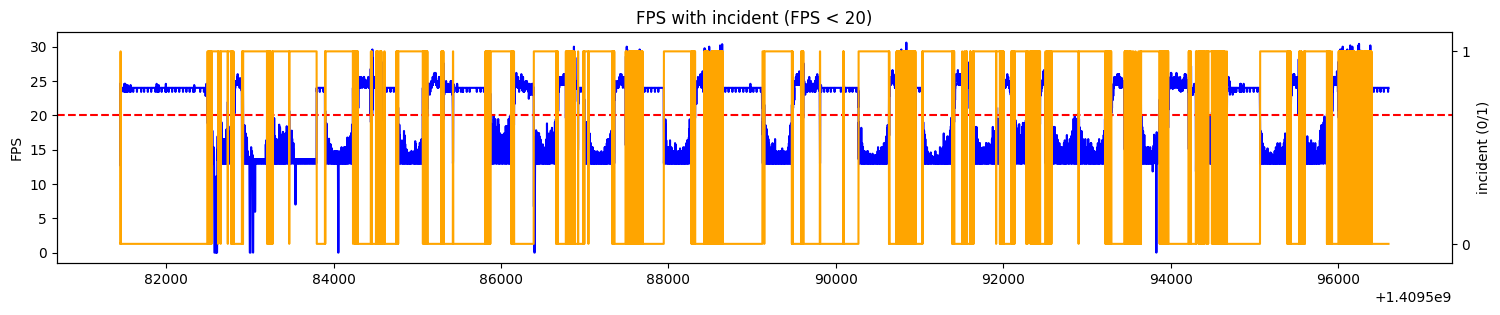

In [5]:
scenario = "flashcrowd_load"

# prepare data for plotting
X = extract_variables(root / "X_SAR" / scenario / "X.csv")
Y = pd.read_csv(root / "X_SAR" / scenario / "Y.csv")[["TimeStamp", "DispFrames", "noAudioPlayed"]]
# comparing server stress and app performance
df = X.merge(Y, on="TimeStamp", how="inner")

# plot user experience
plt.figure(figsize=(18, 2))  
plt.plot(df["TimeStamp"], df["DispFrames"])
plt.axhline(20, color='red', linestyle='--')
plt.title("FPS (DispFrames)")
plt.show()

# plot audio drops
plt.figure(figsize=(18, 2))
plt.plot(df["TimeStamp"], df["noAudioPlayed"])
plt.axhline(20, color='red', linestyle='--') # threshold
plt.title("ABS (noAudioPlayed)")
plt.show()


# here 1 = an app is freezing, 0 = all fine
t = df["TimeStamp"]
fps = df["DispFrames"]
incident = (fps < 20).astype(int)
fig, ax1 = plt.subplots(figsize=(18, 3))
# blue FPS here is actual dropping in performance
ax1.plot(t, fps, color='blue')  
ax1.axhline(20, color='red', linestyle='--')  # threshold
ax1.set_title("FPS with incident (FPS < 20)")
ax1.set_ylabel("FPS")
# orange are incident blocks
ax2 = ax1.twinx()
ax2.plot(t, incident, color='orange')  
ax2.set_ylabel("incident (0/1)")
ax2.set_yticks([0, 1])
ax2.set_ylim(-0.1, 1.1)


1. **Plot DispFrames:** every time that blue line goes below red dotted one, the user is seeing poor performance of a video. 

2. **Plot noAudioPlayed:** when blue line is at 40, the audio has stopped because the system is too stressed (buffer exhaustion). When the blue line is at 0, then the audio is playing well. 

3. **FPS:** here cause and effect is shown: blue line is FPS and orange is binary incident (0 or 1). When orange line is 1, the blue line is below the red dashed line which explains poor performance. 

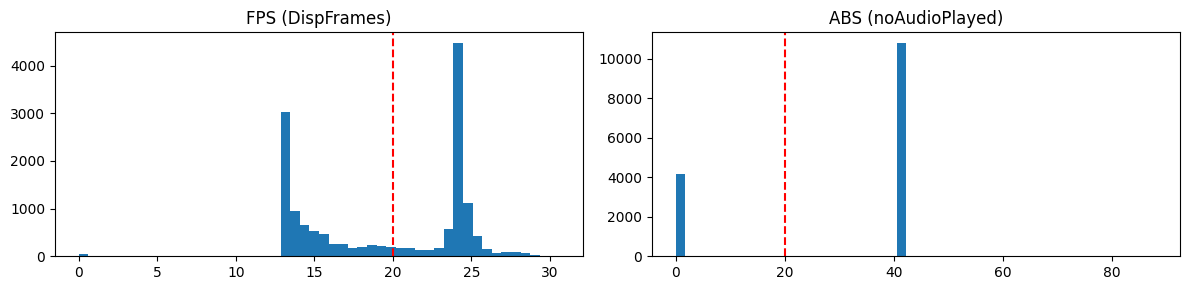

In [6]:
# 2 plots in 1 row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# plot 1: video quality distribution
ax1.hist(Y["DispFrames"].dropna(), bins=50)
ax1.axvline(20, color='red', linestyle='--')
ax1.set_title("FPS (DispFrames)")

# plot 2: Video good = 0 and poor = 40 distribution
ax2.hist(Y["noAudioPlayed"].dropna(), bins=50)
ax2.axvline(20, color='red', linestyle='--')
ax2.set_title("ABS (noAudioPlayed)")

plt.tight_layout()
plt.show()

1. **FPS (DispFrames)** Above 20 part of a histogram is good performance while below 20 is poor. 

2. **ABS (noAudioPlayed)** At 0 every video was playing well. At 40 it fails (like audio stream is droppedto save resources)

---
# **3. PROBLEM FORMULATION**
---

The objective is to predict whether a system failure will occur within a future horizon of $𝐻$ seconds based on the most recent $𝑊$ observations of system metrics.

For each sliding window, summary statistics are computed per metric:

- mean,

- standard deviation,

- minimum,

- maximum,

- last observed value.

This transforms each window into a fixed-length vector, so that ML can be used. Following the methodology discussed in the reference paper, two learning paradigms are investigated:

1. Offline Learning: (i) models are trained once on the training data, (ii) decision threshold is selected on the validation set under a false positive rate  constraint, (iii) performance is evaluated on the unseen test set.

2. Online Learning (i) models updated as new windows arrive, (ii) performance is evaluated on validation and test segments while allowing model updates.

**EVALUATION** 
Given the relevant papers, next metrics were chosen:

PR-AUC (ranking quality under class imbalance),

Precision (alert reliability),

Recall (incident coverage),

F1-score,

Balanced Accuracy,

False Positive Rate, with constraint (≤ 1%).


---
# **4. MODEL: OFFLINE IMPLEMENTATION**
---

### **4.1. Make windows**

Window size was defines as 60 seconds

Horizon size was defined as 30 seconds



In [7]:
# define window size
W, H = 60, 30
scenario = "flashcrowd_load"
X_windows, y, t_idx = make_task_dataset(root, scenario, W=W, H=H)

# define train, validate, test sets
train_idx, val_idx, test_idx = time_split_indices(len(y))

# reshape features into needed format
X2 = summary_features(X_windows)  

X_train, y_train = X2[train_idx], y[train_idx]
X_val,   y_val   = X2[val_idx],   y[val_idx]
X_test,  y_test  = X2[test_idx],  y[test_idx]

t_test = t_idx[test_idx]  # forplots later on 

### **4.2. Define which models to choose and train them**

In accordance with ["Predicting  SLA Violations in Real Time using Online Machine Learning"](https://arxiv.org/abs/1509.01386) paper's narrative, logistic regression and random forest have shown good results so that for this task it was decided to chose these models. The second reason is that I use the same dataset as in the paper and I do believe taht researchers were trying with different models before choosing the best ones.

In [8]:
# train logistic regression
lr = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced", max_iter=1000))
lr.fit(X_train, y_train)
p_val_lr = lr.predict_proba(X_val)[:, 1]

# train random forest
rf = RandomForestClassifier(class_weight="balanced_subsample", random_state=0)
rf.fit(X_train, y_train)
p_val_rf = rf.predict_proba(X_val)[:, 1]

### **4.3. Validate, train, discuss results**
---

In [9]:
# validation 
X_val, y_val = X2[val_idx], y[val_idx]
p_val_lr = lr.predict_proba(X_val)[:, 1]
p_val_rf = rf.predict_proba(X_val)[:, 1]

thr_lr = choose_threshold_fpr_cap(p_val_lr, y_val, fpr_cap=0.01)
thr_rf = choose_threshold_fpr_cap(p_val_rf, y_val, fpr_cap=0.01)

# test 
X_test, y_test = X2[test_idx], y[test_idx]

p_test_lr = lr.predict_proba(X_test)[:, 1]
p_test_rf = rf.predict_proba(X_test)[:, 1]

thr_lr = choose_threshold_fpr_cap(p_val_lr, y_val, fpr_cap=0.01)
thr_rf = choose_threshold_fpr_cap(p_val_rf, y_val, fpr_cap=0.01)

res_lr = evaluate_simple(p_test_lr, y_test, thr_lr)
res_rf = evaluate_simple(p_test_rf, y_test, thr_rf)

# make table with results
rows = []
#  add rows
def add_row(model_name, split_name, p, y, thr):
    pr_auc, precision, recall, f1, ba = evaluate_simple(p, y, thr)
    fpr = fpr_at_threshold(p, y, thr)
    rows.append({
        "Model": model_name,
        "Split": split_name,
        "PR-AUC": pr_auc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Balanced Acc.": ba,
        "FPR": fpr,
        "Threshold": thr,
    })

# validation rows
add_row("LR", "val",  p_val_lr,  y_val,  thr_lr)
add_row("RF", "val",  p_val_rf,  y_val,  thr_rf)

# test rows 
add_row("LR", "test", p_test_lr, y_test, thr_lr)
add_row("RF", "test", p_test_rf, y_test, thr_rf)

results_df = pd.DataFrame(rows)
display(results_df.sort_values(["Model", "Split"]))


,Model,Split,PR-AUC,Precision,Recall,F1,Balanced Acc.,FPR,Threshold
2,LR,test,0.511847,0.476431,0.548450,0.509910,0.540390,0.467669,0.988749
0,LR,val,0.833434,0.972028,0.198006,0.328994,0.594819,0.008368,0.988749
3,RF,test,0.600150,0.960526,0.141473,0.246622,0.568481,0.004511,0.670000
1,RF,val,0.859798,0.981221,0.297721,0.456831,0.644676,0.008368,0.670000


Under careful literature review (see summary.doc) it was decided to use next metrics for model evaluation: 

1. Precision–Recall Area Under Curve

2. Precision

3. Recall 

4. F1 Score

5. Balanced Accuracy

6. False Positive Rate

**RECAP** Starting from a time-series, a sliding-window dataset was constructed. Each example uses the last **W = 60** seconds of system metrics as input. The label is 1 if any incident occurs in the next **H = 30** seconds, otherwise 0. For each window summary features were computed (mean, std, min, max, last value per metric) and model was trained on them. The windows were split: (i) 70% train, (ii) 15% validate, (iii) 15% test. The threshold is FPR ≤ 1% was chosen. Two models were trained on the training windows only. Time series is not assumed to be stationary. The models themselves treat each window as a sample. Models were trained on past windows and test on future windows.

**RESULTS DISCUSSION** While observing the results on test dataset, Logistic regression achieves reasonable recall, but at the cost of an enormous false-positive rate which makes this model unsuitable. In terms of random forest, it almost never raises false alarms, but it misses drop of quality incidents. Both models are unsuitable. 

To take things further, it was proved that the reasons behind poor quality of the models are:

- **offline models assume data comes from a stationary distribution.**

- in real life, system load changes which makes concept drift.

- when you train offline on one trace and test on another, performance is poor

Offline models trained once cannot be trusted under changing load conditions. That is exactly what I observe in my case: (i) train once on past data and fix a model, (ii) fit the model, (iii) evaluate on future data (iv) poor performance.

---
# **5. ONLINE MODEL IMPLEMENTATION**
---

### **5.1. Define class for Hoeffding Trees**
---

In [11]:
class OAUEEnsemble:
    """
    Online Accuracy Updated Ensemble class.
    Hoeffding Trees that update their own weights 
    based on how well they are currently doing. 
    """

    # here hyperparameters are defined
    def __init__(
        self,
        n_estimators: int = 20,             # base Hoeffding Trees
        alpha: float = 0.01,                # smoothing factor
        grace_period: int = 100,            # leaf see before split attempt
        delta: float = 1e-2,                # confidence for bound
        tau: float = 0.05,                  # threshold for tree splitting
    ):
        self.n_estimators = n_estimators
        self.alpha = alpha  # how long keep old performance
        # define pool of trees
        self.models = [
            tree.HoeffdingTreeClassifier(
                grace_period=grace_period,
                delta=delta,
                tau=tau,
            )
            for _ in range(n_estimators)
        ]

        # weights track performance of each tree
        self.weights = np.ones(n_estimators, dtype=float)

    @staticmethod
    def _row_to_dict(x_row: np.ndarray) -> dict:
        """
        convert np array into dict, 
        as required by definition
        """
        return {i: float(v) for i, v in enumerate(x_row)}


    def predict_proba_one(self, x_row: np.ndarray) -> float:
        """
        predicts probability of the positive class (1) for a single input.
        
        returns: normalized weighted average of probabilities from 
        all base learners.
        (weights are based on the learners historical accuracy)
        """
        x = self._row_to_dict(x_row)

        w_sum = 0.0
        p_sum = 0.0

        for w, model in zip(self.weights, self.models):
            # probability predictions for each class
            proba = model.predict_proba_one(x)
            p1 = proba.get(1, 0.5)
            # aggregate weighted probability
            p_sum += w * p1
            w_sum += w

        return p_sum / w_sum if w_sum > 0 else 0.5


    def learn_one(self, x_row: np.ndarray, y_true: int):
        """
        updates ensemble with a new labeled example
        
        (i) evaluate current learners for weights
        (ii) train base learners on the new sample
        """
        x = self._row_to_dict(x_row)
        y_true = int(y_true)

        for i, model in enumerate(self.models):
            # performance before the model learns
            proba = model.predict_proba_one(x)
            p1 = proba.get(1, 0.5)
            y_pred = int(p1 >= 0.5)
            # if individual base learner was correct
            correct = 1.0 if y_pred == y_true else 0.0

            # update weight 
            self.weights[i] = (1 - self.alpha) * self.weights[i] + self.alpha * correct

            model.learn_one(x, y_true)

### **5.2. Define models and split data as offline**
---

In [12]:
rows_online = []

# same split as offline
train_idx, val_idx, test_idx = time_split_indices(len(y))

X_train, y_train = X2[train_idx], y[train_idx]
X_val,   y_val   = X2[val_idx],   y[val_idx]
X_test,  y_test  = X2[test_idx],  y[test_idx]

classes_arr = np.array([0, 1], dtype=int)


# class weights from train
cw = compute_class_weight(class_weight="balanced",
                          classes=classes_arr,
                          y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes_arr, cw)}
print("Class weights (train):", class_weight_dict)

# online logistic regression 
online_lr = SGDClassifier(
    loss="log_loss",
    learning_rate="optimal",
    alpha=1e-4,
    class_weight=class_weight_dict,
    random_state=0,
)
# one partial_fit on train samples
online_lr.partial_fit(X_train, y_train, classes=classes_arr)

# hoeffding trees 
oaue = OAUEEnsemble(
    n_estimators=20,
    alpha=0.01,
    grace_period=100,
    delta=1e-2,
    tau=0.05,
)
# train sequentially 
for xi, yi in zip(X_train, y_train):
    oaue.learn_one(xi, int(yi))

Class weights (train): {np.int64(0): np.float64(0.70698510529019), np.int64(1): np.float64(1.7078163771712158)}


In [13]:

# validation
p_val_lr = online_lr.predict_proba(X_val)[:, 1]
p_val_oa = np.array([oaue.predict_proba_one(xi) for xi in X_val])

# test
p_test_lr = online_lr.predict_proba(X_test)[:, 1]
p_test_oa = np.array([oaue.predict_proba_one(xi) for xi in X_test])


# threshold same as offline
FPR_CAP = 0.01

thr_lr  = choose_threshold_fpr_cap(p_val_lr, y_val, fpr_cap=FPR_CAP)
thr_oa  = choose_threshold_fpr_cap(p_val_oa, y_val, fpr_cap=FPR_CAP)

print("Online LR threshold:", thr_lr)
print("OAUE threshold     :", thr_oa)


# make a table same as offline

def add_row(model_name, split_name, p, y_true, thr):
    pr_auc, prec, rec, f1, ba = evaluate_simple(p, y_true, thr)
    fpr = fpr_at_threshold(p, y_true, thr)
    rows_online.append({
        "Model": model_name,
        "Split": split_name,
        "PR-AUC": pr_auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Balanced Acc.": ba,
        "FPR": fpr,
        "Threshold": thr,
    })


# put data in tables
# validation
add_row("Online LR",  "val",  p_val_lr,  y_val,  thr_lr)
add_row("Online OAUE","val",  p_val_oa,  y_val,  thr_oa)

# test
add_row("Online LR",  "test", p_test_lr, y_test, thr_lr)
add_row("Online OAUE","test", p_test_oa, y_test, thr_oa)

online_table = pd.DataFrame(rows_online)
display(online_table.sort_values(["Model", "Split"]))

Online LR threshold: 0.0
OAUE threshold     : 0.9085184707566806


,Model,Split,PR-AUC,Precision,Recall,F1,Balanced Acc.,FPR,Threshold
2,Online LR,test,0.436918,0.436918,1.000000,0.608132,0.500000,1.000000,0.000000
0,Online LR,val,0.594915,0.594915,1.000000,0.746015,0.500000,1.000000,0.000000
3,Online OAUE,test,0.501647,0.450450,0.096899,0.159490,0.502585,0.091729,0.908518
1,Online OAUE,val,0.845316,0.986842,0.213675,0.351288,0.604746,0.004184,0.908518


Given the limitations observed in the offline models and the non-stationary nature of system monitoring data, online learning methods were investigated.

The same sliding-window formulation was retained:

- Look-back window: W = 60

- Prediction horizon: H = 30

- Same summary features per window

- Same split (70% train, 15% validation, 15% test)

Advantages: (models updated sequentially using new windows)

Models used: 

1. Online Logistic Regression 

2. Online ensemble of Hoeffding trees 

The online models were expected to adapt to potential distribution shifts and maintain stable performance under non-stationarity. But empirical evaluation indicates: 

(i) online logistic regression became unstable

(ii) Hoeffding-tree ensemble did not outperform the offline random forest

**It is belieded that a deep dive into online models is needed, since for this specific task the methodology was changed. After careful consideration and additional study of online models it is believed that they should outperform offline ones

---
# **6. ADDITIONAL METRICS FOR ONLINE METHODS** 
---

In [20]:
def rolling_far_ba(y, yhat, x, window=500):
    y = np.asarray(y).astype(int)
    yhat = np.asarray(yhat).astype(int)
    x = np.asarray(x)

    n = len(y)
    w = int(window)
    if w < 1:
        raise ValueError("window must be >= 1")

    tp = ((yhat == 1) & (y == 1)).astype(int)
    fp = ((yhat == 1) & (y == 0)).astype(int)
    tn = ((yhat == 0) & (y == 0)).astype(int)
    fn = ((yhat == 0) & (y == 1)).astype(int)

    def csum(a):
        return np.concatenate([[0], np.cumsum(a)])

    tp_c, fp_c, tn_c, fn_c = csum(tp), csum(fp), csum(tn), csum(fn)

    start = np.clip(np.arange(n) - w + 1, 0, n)
    end = np.arange(n) + 1

    TP = tp_c[end] - tp_c[start]
    FP = fp_c[end] - fp_c[start]
    TN = tn_c[end] - tn_c[start]
    FN = fn_c[end] - fn_c[start]

    FAR = FP / np.maximum(FP + TN, 1)
    TPR = TP / np.maximum(TP + FN, 1)
    TNR = TN / np.maximum(TN + FP, 1)
    BA  = 0.5 * (TPR + TNR)

    return x, FAR, BA


def plot_far_ba(x, far, ba, title="", fpr_cap=0.01):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # rolling FAR
    axes[0].plot(x, far)
    axes[0].axhline(fpr_cap, linestyle="--")
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("False Positive Rate")
    axes[0].set_title(f"{title} rolling False positive rate")

    # rolling BA
    axes[1].plot(x, ba)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("Balanced accuracy")
    axes[1].set_title(f"{title} rolling Balanced accuracy")

    plt.tight_layout()
    plt.show()

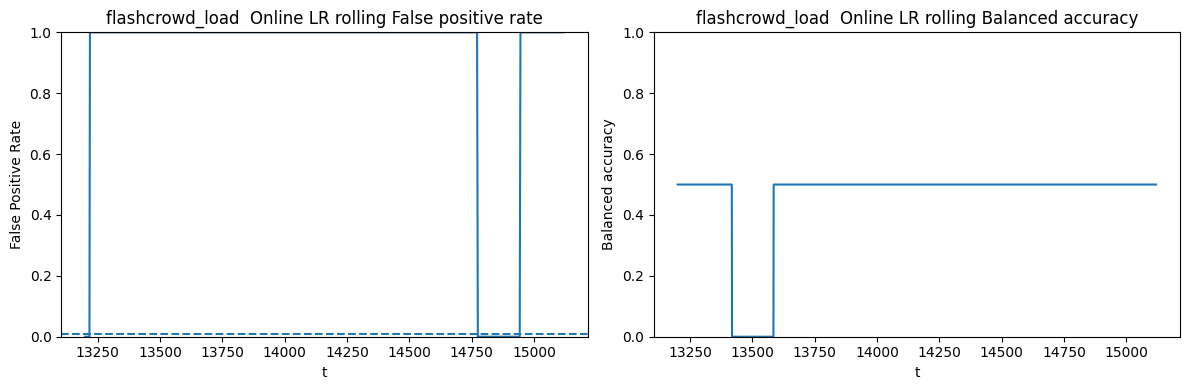

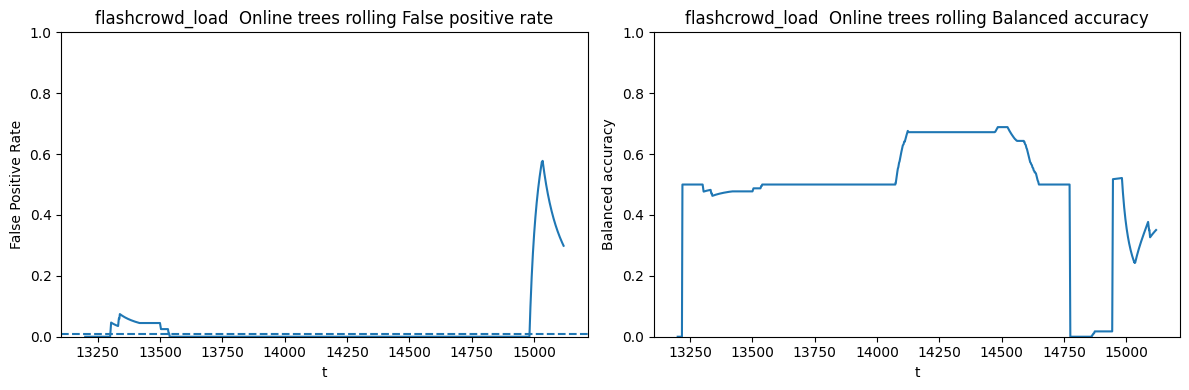

In [21]:
# binary predictions on test (ONLINE models only)
yhat_lr_online = (p_test_lr >= thr_lr).astype(int)
yhat_oa_online = (p_test_oa >= thr_oa).astype(int)

# rolling window (same heuristic as before)
WROLL = max(200, len(y_test) // 20)

# Online LR rolling FAR & BA
x_lr, far_lr, ba_lr = rolling_far_ba(
    y=y_test,
    yhat=yhat_lr_online,
    x=t_test,
    window=WROLL,
)
plot_far_ba(
    x_lr,
    far_lr,
    ba_lr,
    title=f"{scenario}  Online LR",
    fpr_cap=0.01,
)

# OAUE rolling FAR & BA
x_oa, far_oa, ba_oa = rolling_far_ba(
    y=y_test,
    yhat=yhat_oa_online,
    x=t_test,
    window=WROLL,
)
plot_far_ba(
    x_oa,
    far_oa,
    ba_oa,
    title=f"{scenario}  Online trees",
    fpr_cap=0.01,
)